In [ ]:
copyright@Lettie
此程序处理所有原始数据表，获得回归模型中所需要的所有变量的干净数据

步骤包括：
数值型数据的基本处理
分类变量的构建
较复杂的变量处理（包含数学模型）


# 读取数据表

In [1]:
import os
import pandas as pd

# Get the current directory
current_directory = os.getcwd()

# List all Excel files in the directory
excel_files = [f for f in os.listdir(current_directory) if f.endswith(('.xls', '.xlsx'))]

# Read all Excel files into a dictionary of DataFrames
excel_data = {file: pd.read_excel(file) for file in excel_files}

# Display the names of the files and their corresponding DataFrames
for file, df in excel_data.items():
    print(f"Data from {file}:")
    print(df.head())  # Display the first few rows of each DataFrame

Data from app_solver_profile.xlsx:
     userid  skill1_count  skill1_id             skill1_name  \
0    649325            51          3                     PHP   
1   2791070            40         44  Mobile App Development   
2  18084538            33         44  Mobile App Development   
3  41520193             9          9              JavaScript   
4   2790572             5        690                 ASP.NET   

             skill1_category  skill1_category_id  skill2_count  skill2_id  \
0    Websites, IT & Software                   1            26         17   
1  Mobile Phones & Computing                   9            35         59   
2  Mobile Phones & Computing                   9            24         59   
3    Websites, IT & Software                   1             8        335   
4    Websites, IT & Software                   1             5        106   

      skill2_name               skill2_category  ...  phone_verified  \
0  Website Design  Design, Media & Architectu

In [2]:
excel_files

['app_solver_profile.xlsx',
 'bid_sentences.xlsx',
 'app_solver_review.xlsx',
 'bid_predictions.xlsx',
 'app_bid.xlsx',
 'data.xlsx',
 'data_cleaned.xlsx',
 'training_sample_sentence.xlsx',
 'app_project_list.xlsx',
 'app_seeker_profile.xlsx']

In [3]:
bid_predictions = excel_data['bid_predictions.xlsx']
bid_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258861 entries, 0 to 258860
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   bid                         258861 non-null  int64 
 1   sentences                   242678 non-null  object
 2   Unnamed: 2                  49 non-null      object
 3   Unnamed: 3                  28 non-null      object
 4   Unnamed: 4                  16 non-null      object
 5   Unnamed: 5                  13 non-null      object
 6   Unnamed: 6                  8 non-null       object
 7   Unnamed: 7                  5 non-null       object
 8   Unnamed: 8                  2 non-null       object
 9   Unnamed: 9                  2 non-null       object
 10  Unnamed: 10                 2 non-null       object
 11  Unnamed: 11                 2 non-null       object
 12  Unnamed: 12                 2 non-null       object
 13  Unnamed: 13                 1

In [4]:
app_solver_review = excel_data['app_solver_review.xlsx']
app_solver_review.sample(5)

,pid,to_user_id,from_user_id,task_status,time_submit,rating,description,professionalism,communication,quality,hire_again,expertise,on_time,on_budge,bid_amount,paid_amount,id
93,23398868,33436576,41549808,complete,2020-01-16 16:47:10,5.0,الأستاذة مرام من الشخصيات المميزة التي تعاملت ...,5,5,5,5,5,1,1,100,100.0,14639112
68,23417823,29047606,25888734,complete,2020-01-17 07:13:24,5.0,Great work as always,5,5,5,5,5,1,1,90,90.0,14644002
160,23398539,13598097,42721065,complete,2020-02-03 19:53:55,5.0,Great work and communicates well and explains ...,5,5,5,5,5,1,0,777,1500.0,14770766
183,23388718,32777940,14539514,complete,2020-01-31 23:41:18,5.0,Vandana completed my project perfectly on time...,5,5,5,5,5,1,1,1500,1500.0,14750922
251,23327762,26736603,4375333,complete,2020-01-16 00:27:45,5.0,Highly recommended the best service I've recei...,5,5,5,5,5,1,1,15,27.0,14634923


In [5]:
# 综合评分计算（不包含on_time和on_budge）
rating_columns = ['professionalism', 'communication', 'quality', 'hire_again', 'expertise']
app_solver_review['average_rating'] = app_solver_review[rating_columns].mean(axis=1)


In [6]:
from textblob import TextBlob

# 定义情感分析函数
def get_sentiment(description):
    if isinstance(description, str):
        analysis = TextBlob(description)
        # 获取情感得分，范围为 [-1, 1]，正值表示正面，负值表示负面
        return analysis.sentiment.polarity
    else:
        return 0

# 应用情感分析到 description 字段
app_solver_review['sentiment_score'] = app_solver_review['description'].apply(get_sentiment)


In [7]:
# 计算每个 to_user_id 收到的评论数量
app_solver_review['review_count'] = app_solver_review.groupby('to_user_id')['to_user_id'].transform('count')

# 按 to_user_id 汇总 sentiment_score, average_rating, 和 review_count
solver_summary = app_solver_review.groupby('to_user_id').agg({
    'sentiment_score': 'mean',
    'average_rating': 'mean',
    'review_count': 'first'  # 使用 'first' 来获取评论数量，因为它在分组后是相同的
}).reset_index()

In [8]:
solver_summary

,to_user_id,sentiment_score,average_rating,review_count
0,81607,0.366667,5.0,1
1,354251,0.158333,5.0,1
2,368145,0.466667,5.0,1
3,398434,0.800000,5.0,1
4,494251,0.200000,4.8,1
...,...,...,...,...
243,42740528,0.262500,5.0,1
244,42771940,0.700000,4.2,1
245,42808214,0.465000,5.0,1
246,42808557,0.000000,0.0,1


In [9]:
app_solver_profile = excel_data['app_solver_profile.xlsx']
app_solver_profile.sample(5)

,userid,skill1_count,skill1_id,skill1_name,skill1_category,skill1_category_id,skill2_count,skill2_id,skill2_name,skill2_category,...,phone_verified,identity_verified,facebook_connected,freelancer_verified,primary_currency,exchange_rate,primary_language,timezone,is_profile_visible,reg_date
3583,21872191,8,9,JavaScript,"Websites, IT & Software",1,6,6,C Programming,"Websites, IT & Software",...,1,1,1,0,USD,1.000000,en,America/Sao_Paulo,1,2016-09-11 00:00:00
3049,41619528,0,0,NaN,NaN,0,0,0,NaN,NaN,...,0,0,0,0,INR,0.013699,en,Asia/Kolkata,1,27/11/2019
2239,3146904,2091,38,SEO,"Websites, IT & Software",1,1884,40,Link Building,"Websites, IT & Software",...,1,1,0,0,USD,1.000000,en,Asia/Kolkata,1,2012-08-01 00:00:00
112,29749470,53,44,Mobile App Development,Mobile Phones & Computing,9,50,59,Android,Mobile Phones & Computing,...,1,1,1,1,INR,0.013686,en,Asia/Kolkata,1,29/5/2018
433,72482,9,3,PHP,"Websites, IT & Software",1,4,44,Mobile App Development,Mobile Phones & Computing,...,1,1,0,0,USD,1.000000,en,Asia/Calcutta,1,2005-10-06 00:00:00


In [10]:
app_solver_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   userid               6727 non-null   int64         
 1   skill1_count         6727 non-null   int64         
 2   skill1_id            6727 non-null   int64         
 3   skill1_name          3725 non-null   object        
 4   skill1_category      3725 non-null   object        
 5   skill1_category_id   6727 non-null   int64         
 6   skill2_count         6727 non-null   int64         
 7   skill2_id            6727 non-null   int64         
 8   skill2_name          3633 non-null   object        
 9   skill2_category      3633 non-null   object        
 10  skill2_category_id   6727 non-null   int64         
 11  skill3_count         6727 non-null   int64         
 12  skill3_id            6727 non-null   int64         
 13  skill3_name          3496 non-nul

# Prifile 数据的处理

In [11]:
# 计算 Profile 完整度
profile_columns = ['phone_verified', 'identity_verified', 'facebook_connected', 'freelancer_verified']
app_solver_profile['profile_completeness'] = app_solver_profile[profile_columns].mean(axis=1)


In [12]:
# 合并数据表，并填充空值为0
final_data = app_solver_profile.merge(solver_summary, left_on='userid', right_on='to_user_id', how='left').fillna(0)

# 选择所需列
final_solver_summary = final_data[['userid', 'profile_completeness', 'average_rating', 'sentiment_score', 'review_count']]


In [13]:
final_solver_summary.sample(10)

,userid,profile_completeness,average_rating,sentiment_score,review_count
4280,32012205,0.50,0.0,0.0,0.0
672,9426577,0.75,0.0,0.0,0.0
5752,1029866,0.00,0.0,0.0,0.0
2103,1110077,0.50,0.0,0.0,0.0
3840,9954395,0.50,0.0,0.0,0.0
452,17379014,0.50,0.0,0.0,0.0
693,28691851,0.75,0.0,0.0,0.0
963,29277662,0.75,0.0,0.0,0.0
1267,42511826,0.25,0.0,0.0,0.0
6718,27821326,0.75,0.0,0.0,0.0


# 熵权法和 TOPSIS--构建solver star

（文字可以直接用之前美赛写的）
使用熵权法和 TOPSIS 方法对每个 solver 进行评级的步骤如下：

## 1. 熵权法计算指标权重
熵权法是一种客观分配指标权重的方法。熵值越高，说明该指标的分散性越低，因此权重越低。计算步骤包括：

标准化数据。
计算每个指标的熵值。
根据熵值计算权重。
## 2. TOPSIS 方法
TOPSIS（Technique for Order of Preference by Similarity to Ideal Solution）用于根据指标的权重进行评分，靠近理想解的方案排名靠前。具体步骤包括：

## 3.标准化数据。
加权后的标准化矩阵。
计算理想解和负理想解。
计算每个方案与理想解及负理想解的距离。
计算每个方案的得分（接近理想解的程度）。

In [14]:
import numpy as np

# 提取指标列
data = final_solver_summary[['profile_completeness', 'average_rating', 'sentiment_score', 'review_count']]

# 1. 数据标准化处理 (Min-Max Normalization)
normalized_data = (data - data.min()) / (data.max() - data.min())

# 2. 计算熵值
eps = 1e-10  # 防止出现log(0)的情况
p = normalized_data / normalized_data.sum(axis=0)
entropy = -np.nansum(p * np.log(p + eps), axis=0) / np.log(len(data))

# 3. 计算权重 (1 - 熵值) / 总和
d = 1 - entropy
weights = d / d.sum()

# 4. 计算加权标准化矩阵
weighted_data = normalized_data * weights

# 5. 计算理想解和负理想解
ideal_solution = weighted_data.max(axis=0)
negative_ideal_solution = weighted_data.min(axis=0)

# 6. 计算每个solver与理想解和负理想解的距离
dist_to_ideal = np.sqrt(((weighted_data - ideal_solution) ** 2).sum(axis=1))
dist_to_negative_ideal = np.sqrt(((weighted_data - negative_ideal_solution) ** 2).sum(axis=1))

# 7. 计算每个solver的得分
topsis_score = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)

# 将 TOPSIS 评分加入结果表格
#使用 .loc 来分配新的列
final_solver_summary.loc[:, 'topsis_score'] = topsis_score



/var/folders/zw/fw6v5m1n6q7f6fjbz7q97b6c0000gp/T/ipykernel_33374/3952452575.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_solver_summary.loc[:, 'topsis_score'] = topsis_score


In [15]:
final_solver_summary

,userid,profile_completeness,average_rating,sentiment_score,review_count,topsis_score
0,649325,0.75,0.0,0.0,0.0,0.031847
1,2791070,0.75,0.0,0.0,0.0,0.031847
2,18084538,0.75,0.0,0.0,0.0,0.031847
3,41520193,0.50,0.0,0.0,0.0,0.021459
4,2790572,0.50,0.0,0.0,0.0,0.021459
...,...,...,...,...,...,...
6722,42185641,0.25,0.0,0.0,0.0,0.010851
6723,32186521,0.25,0.0,0.0,0.0,0.010851
6724,19356826,0.25,0.0,0.0,0.0,0.010851
6725,30298238,0.25,0.0,0.0,0.0,0.010851


## 根据topsis_score绘制solver评分的分布图

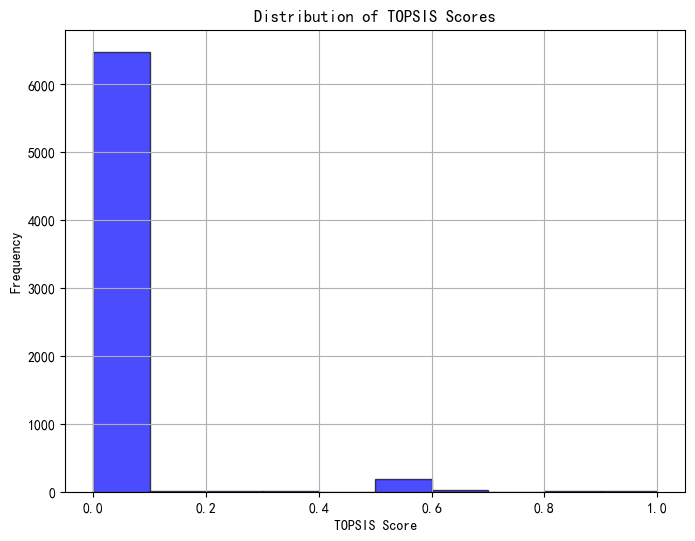

In [17]:

import matplotlib.pyplot as plt

# 绘制 TOPSIS 评分的分布图
plt.figure(figsize=(8, 6))
plt.hist(final_solver_summary['topsis_score'], bins=10, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of TOPSIS Scores')
plt.xlabel('TOPSIS Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## 绘制 TOPSIS 评分的散点图

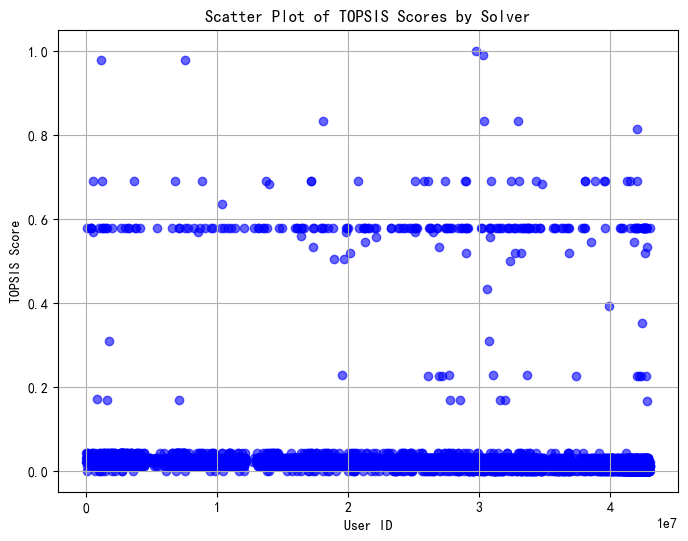

In [18]:

plt.figure(figsize=(8, 6))
plt.scatter(final_solver_summary['userid'], final_solver_summary['topsis_score'], color='blue', alpha=0.6)
plt.title('Scatter Plot of TOPSIS Scores by Solver')
plt.xlabel('User ID')
plt.ylabel('TOPSIS Score')
plt.grid(True)
plt.show()


## 通过聚类将userid进行分类（自动选择合适的类别
通过聚类将userid进行分类（自动选择合适的类别），比较不同类别的topsis_score，加一列solver星级，表示solver的等级，等级越高代表其所在的类别的topsis_score整体更高

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 对 TOPSIS 评分进行聚类
scaler = StandardScaler()
topsis_scores_scaled = scaler.fit_transform(final_solver_summary[['topsis_score']])

# 使用肘部法则自动选择合适的聚类数量 (通过KMeans的方法来估计)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(topsis_scores_scaled)
    inertia.append(kmeans.inertia_)

# 通过KMeans进行聚类，并选择合适的类别
optimal_clusters = 3  # 为了简化，直接设置为3个类别
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_solver_summary['cluster'] = kmeans.fit_predict(topsis_scores_scaled)

# 比较每个类别的 TOPSIS 得分
cluster_scores = final_solver_summary.groupby('cluster')['topsis_score'].mean().reset_index()
cluster_scores = cluster_scores.sort_values('topsis_score', ascending=False)

# 根据每个类别的平均TOPSIS评分，分配solver星级
cluster_scores['solver_star'] = range(len(cluster_scores) ,0, -1)

# 将星级分配回原始表格
solver_summary_data = final_solver_summary.merge(cluster_scores[['cluster', 'solver_star']], on='cluster', how='left')


/var/folders/zw/fw6v5m1n6q7f6fjbz7q97b6c0000gp/T/ipykernel_33374/1786619282.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_solver_summary['cluster'] = kmeans.fit_predict(topsis_scores_scaled)


In [20]:
solver_summary_data.sample(10)

,userid,profile_completeness,average_rating,sentiment_score,review_count,topsis_score,cluster,solver_star
5886,25084850,0.50,0.0,0.0,0.0,0.021459,0,1
2825,31874814,0.50,0.0,0.0,0.0,0.021459,0,1
3009,23369721,0.50,0.0,0.0,0.0,0.021459,0,1
2022,24288455,0.75,0.0,0.0,0.0,0.031847,0,1
5354,42395036,0.25,0.0,0.0,0.0,0.010851,0,1
3682,42032592,0.25,0.0,0.0,0.0,0.010851,0,1
4916,41695796,0.25,0.0,0.0,0.0,0.010851,0,1
1403,36311190,0.50,0.0,0.0,0.0,0.021459,0,1
708,39634485,0.50,0.0,0.0,0.0,0.021459,0,1
3712,41127180,0.25,0.0,0.0,0.0,0.010851,0,1


In [21]:
cluster_scores

,cluster,topsis_score,solver_star
2,2,0.736715,3
1,1,0.567640,2
0,0,0.019336,1


# 合并profile（没太大用）

# 汇率的统一与时差的计算
抽取solverprofile（excel_data['app_solver_profile.xlsx']）当中的汇率（exchange_rate）和时区（timezone）信息，新建一个dataframe

In [22]:
df = excel_data['app_solver_profile.xlsx']
df.rename(columns={'timezone': 'solver_timezone','userid': 'solverid'}, inplace=True)
selected_solver_profile = df[['solverid','exchange_rate', 'solver_timezone']]
selected_solver_profile

,solverid,exchange_rate,solver_timezone
0,649325,1.000000,Africa/Cairo
1,2791070,0.013723,Asia/Calcutta
2,18084538,0.013799,Asia/Kolkata
3,41520193,1.000000,Europe/Moscow
4,2790572,0.013723,Asia/Calcutta
...,...,...,...
6722,42185641,1.000000,America/Costa_Rica
6723,32186521,1.000000,Asia/Jakarta
6724,19356826,0.013803,Asia/Kolkata
6725,30298238,0.013511,Asia/Kolkata


In [23]:
df = excel_data['app_seeker_profile.xlsx']
df.rename(columns={'timezone': 'seeker_timezone','userid': 'seekerid'}, inplace=True)
selected_seeker_profile = df[['seekerid', 'seeker_timezone']]
#'exchange_rate',
selected_seeker_profile

,seekerid,seeker_timezone
0,14048114,Asia/Jerusalem
1,41545230,America/Edmonton
2,8724609,Europe/London
3,32633957,Europe/Minsk
4,29887395,Europe/Paris
...,...,...
2548,35772586,Asia/Kolkata
2549,42828674,Asia/Riyadh
2550,42750870,Africa/Abidjan
2551,42836396,Africa/Abidjan


In [24]:
df = excel_data['app_project_list.xlsx']
#df.rename(columns={'timezone': 'seeker_timezone'}, inplace=True)
df = df[df['hireme'] == 0]
selected_app_project_list = df[['pid','seekerid', 'bid_count','bidperiod']]
selected_app_project_list

,pid,seekerid,bid_count,bidperiod
0,20291674,35802857,32,196
1,22835891,41986540,42,30
2,22875715,35717977,35,7
3,23007025,26141316,10,25
4,23027738,18703514,31,28
...,...,...,...,...
3024,23522733,29540942,196,7
3025,23522858,42677398,6,7
3026,23522911,40292726,82,7
3027,23522945,42897877,23,7


In [25]:
df = excel_data['app_bid.xlsx']
df.rename(columns={'userid': 'solverid'}, inplace=True)
selected_app_bid = df[['bid','pid','solverid','description', 'period','price','award_status']]
selected_app_bid

,bid,pid,solverid,description,period,price,award_status
0,256634717,23522945,27933368,"Hello There,This is Ravindra, and I am a top-r...",7,25000,NaN
1,256629301,23522945,23093057,"Hello ,I am Flutter Mobile app development Exp...",7,25000,NaN
2,256626727,23522945,22099154,"Hi,I've reviewed your job description very car...",7,45000,NaN
3,256672268,23522945,21247335,"Hi Dear, I can sure help you to develop your F...",15,35000,NaN
4,256626475,23522945,30049860,"Hello,Yes, We work on Flutter in a very well m...",19,37500,NaN
...,...,...,...,...,...,...,...
62692,254764838,23290756,30606180,"Hello,Thanks for opportunity to bid. I would l...",7,7000,NaN
62693,254757203,23290756,30298238,I have read all your requirements.Can we Start??,3,7222,NaN
62694,254757463,23290756,41466158,"Hello Sir,My greetings to you. This is Khushbu...",7,12500,NaN
62695,254765999,23290756,42290467,"Hi Sir,I am interested in your project,Thanks ...",20,12500,NaN


# 合并数据表

In [26]:
# 进行外连接合并 pid:seekerid = n:1, so left merge
merged_data_project_on_seeker = pd.merge(
    selected_app_project_list,
    selected_seeker_profile,
    on='seekerid',
    how='left',
)
merged_data_project_on_seeker

,pid,seekerid,bid_count,bidperiod,seeker_timezone
0,20291674,35802857,32,196,Asia/Vladivostok
1,22835891,41986540,42,30,Africa/Abidjan
2,22875715,35717977,35,7,Pacific/Auckland
3,23007025,26141316,10,25,Asia/Karachi
4,23027738,18703514,31,28,Asia/Almaty
...,...,...,...,...,...
2659,23522733,29540942,196,7,Asia/Dubai
2660,23522858,42677398,6,7,Europe/Amsterdam
2661,23522911,40292726,82,7,America/New_York
2662,23522945,42897877,23,7,Asia/Kolkata


In [27]:
# 进行外连接合并 pid:solverid = n:m, so left merge
merged_data_app_bid_on_solver = pd.merge(
    selected_app_bid,
    selected_solver_profile,
    on='solverid',
    how='left',
)
merged_data_app_bid_on_solver

,bid,pid,solverid,description,period,price,award_status,exchange_rate,solver_timezone
0,256634717,23522945,27933368,"Hello There,This is Ravindra, and I am a top-r...",7,25000,NaN,0.013789,Asia/Calcutta
1,256629301,23522945,23093057,"Hello ,I am Flutter Mobile app development Exp...",7,25000,NaN,0.013810,Asia/Calcutta
2,256626727,23522945,22099154,"Hi,I've reviewed your job description very car...",7,45000,NaN,0.013808,Asia/Calcutta
3,256672268,23522945,21247335,"Hi Dear, I can sure help you to develop your F...",15,35000,NaN,0.013785,Asia/Kolkata
4,256626475,23522945,30049860,"Hello,Yes, We work on Flutter in a very well m...",19,37500,NaN,1.000000,Asia/Kolkata
...,...,...,...,...,...,...,...,...,...
62692,254764838,23290756,30606180,"Hello,Thanks for opportunity to bid. I would l...",7,7000,NaN,0.013524,Asia/Kolkata
62693,254757203,23290756,30298238,I have read all your requirements.Can we Start??,3,7222,NaN,0.013511,Asia/Kolkata
62694,254757463,23290756,41466158,"Hello Sir,My greetings to you. This is Khushbu...",7,12500,NaN,1.000000,Asia/Kolkata
62695,254765999,23290756,42290467,"Hi Sir,I am interested in your project,Thanks ...",20,12500,NaN,0.013686,Asia/Kolkata


In [28]:
# 进行外连接合并 pid:solverid = n:m, pid:seekerid = n:1, so left merge
merged_data = pd.merge(
    merged_data_app_bid_on_solver,
    merged_data_project_on_seeker,
    on='pid',
    how='left',
)
merged_data

,bid,pid,solverid,description,period,price,award_status,exchange_rate,solver_timezone,seekerid,bid_count,bidperiod,seeker_timezone
0,256634717,23522945,27933368,"Hello There,This is Ravindra, and I am a top-r...",7,25000,NaN,0.013789,Asia/Calcutta,42897877.0,23.0,7.0,Asia/Kolkata
1,256629301,23522945,23093057,"Hello ,I am Flutter Mobile app development Exp...",7,25000,NaN,0.013810,Asia/Calcutta,42897877.0,23.0,7.0,Asia/Kolkata
2,256626727,23522945,22099154,"Hi,I've reviewed your job description very car...",7,45000,NaN,0.013808,Asia/Calcutta,42897877.0,23.0,7.0,Asia/Kolkata
3,256672268,23522945,21247335,"Hi Dear, I can sure help you to develop your F...",15,35000,NaN,0.013785,Asia/Kolkata,42897877.0,23.0,7.0,Asia/Kolkata
4,256626475,23522945,30049860,"Hello,Yes, We work on Flutter in a very well m...",19,37500,NaN,1.000000,Asia/Kolkata,42897877.0,23.0,7.0,Asia/Kolkata
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62692,254764838,23290756,30606180,"Hello,Thanks for opportunity to bid. I would l...",7,7000,NaN,0.013524,Asia/Kolkata,42575849.0,15.0,7.0,Asia/Kolkata
62693,254757203,23290756,30298238,I have read all your requirements.Can we Start??,3,7222,NaN,0.013511,Asia/Kolkata,42575849.0,15.0,7.0,Asia/Kolkata
62694,254757463,23290756,41466158,"Hello Sir,My greetings to you. This is Khushbu...",7,12500,NaN,1.000000,Asia/Kolkata,42575849.0,15.0,7.0,Asia/Kolkata
62695,254765999,23290756,42290467,"Hi Sir,I am interested in your project,Thanks ...",20,12500,NaN,0.013686,Asia/Kolkata,42575849.0,15.0,7.0,Asia/Kolkata


In [29]:
df = merged_data.copy()

In [30]:
df['std_award_status'] = df['award_status'].notnull().astype(int)

In [31]:
df['std_price'] = df['price'] * df['exchange_rate']

In [32]:
df['word'] = df['description'].str.split().str.len()

In [33]:

import pytz

def calculate_time_diff(row):
    try:
        # Ensure that timezone columns are strings
        solver_tz_name = str(row['solver_timezone'])
        seeker_tz_name = str(row['seeker_timezone'])

        # Get the timezones
        solver_tz = pytz.timezone(solver_tz_name)
        seeker_tz = pytz.timezone(seeker_tz_name)

        # Get the current time in UTC
        now = pd.Timestamp.now(tz='UTC')

        # Convert to the respective timezones
        solver_time = now.tz_convert(solver_tz)
        seeker_time = now.tz_convert(seeker_tz)

        # Calculate time difference in hours
        time_diff = (solver_time.utcoffset() - seeker_time.utcoffset()).total_seconds() / 3600
        return time_diff
    except (pytz.UnknownTimeZoneError, AttributeError, ValueError) as e:
        # Handle invalid timezone or missing data
        #print(f"Error processing row: {row} - {e}")
        return None

# Apply function and create new column
df['time_diff'] = df.apply(calculate_time_diff, axis=1)


In [34]:
df.drop(columns=['award_status', 'exchange_rate', 'solver_timezone', 'seeker_timezone','bidperiod'], inplace=True)


## 合并solver情况

In [35]:


# 现在我们将 'df' 与 'final_solver_summary' 基于 'solverid' 和 'userid' 合并
merged_data = df.merge(solver_summary_data, left_on='solverid', right_on='userid', how='left')


In [36]:
null_counts = merged_data.isnull().sum()
print(null_counts)

bid                       0
pid                       0
solverid                  0
description             259
period                    0
price                     0
seekerid                300
bid_count               300
std_award_status          0
std_price                 0
word                    260
time_diff               300
userid                    0
profile_completeness      0
average_rating            0
sentiment_score           0
review_count              0
topsis_score              0
cluster                   0
solver_star               0
dtype: int64


In [37]:
# 按行删除：存在空值，即删除该行
df = merged_data.dropna()

In [38]:
df

,bid,pid,solverid,description,period,price,seekerid,bid_count,std_award_status,std_price,word,time_diff,userid,profile_completeness,average_rating,sentiment_score,review_count,topsis_score,cluster,solver_star
0,256634717,23522945,27933368,"Hello There,This is Ravindra, and I am a top-r...",7,25000,42897877.0,23.0,0,344.725000,79.0,0.0,27933368,1.00,0.0,0.000000,0.0,0.042018,0,1
1,256629301,23522945,23093057,"Hello ,I am Flutter Mobile app development Exp...",7,25000,42897877.0,23.0,0,345.250000,31.0,0.0,23093057,0.75,0.0,0.000000,0.0,0.031847,0,1
2,256626727,23522945,22099154,"Hi,I've reviewed your job description very car...",7,45000,42897877.0,23.0,0,621.360000,82.0,0.0,22099154,0.50,5.0,0.466667,1.0,0.577881,1,2
3,256672268,23522945,21247335,"Hi Dear, I can sure help you to develop your F...",15,35000,42897877.0,23.0,0,482.475000,123.0,0.0,21247335,0.50,5.0,0.362500,1.0,0.577881,1,2
4,256626475,23522945,30049860,"Hello,Yes, We work on Flutter in a very well m...",19,37500,42897877.0,23.0,0,37500.000000,83.0,0.0,30049860,0.75,0.0,0.000000,0.0,0.031847,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62692,254764838,23290756,30606180,"Hello,Thanks for opportunity to bid. I would l...",7,7000,42575849.0,15.0,0,94.668000,50.0,0.0,30606180,0.50,0.0,0.000000,0.0,0.021459,0,1
62693,254757203,23290756,30298238,I have read all your requirements.Can we Start??,3,7222,42575849.0,15.0,0,97.576442,8.0,0.0,30298238,0.25,0.0,0.000000,0.0,0.010851,0,1
62694,254757463,23290756,41466158,"Hello Sir,My greetings to you. This is Khushbu...",7,12500,42575849.0,15.0,0,12500.000000,99.0,0.0,41466158,0.25,0.0,0.000000,0.0,0.010851,0,1
62695,254765999,23290756,42290467,"Hi Sir,I am interested in your project,Thanks ...",20,12500,42575849.0,15.0,0,171.075000,81.0,0.0,42290467,0.25,0.0,0.000000,0.0,0.010851,0,1


In [39]:
df.rename(columns={'period': 'DDelivery','bid_count':'competition'}, inplace=True)

/var/folders/zw/fw6v5m1n6q7f6fjbz7q97b6c0000gp/T/ipykernel_33374/818399972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'period': 'DDelivery','bid_count':'competition'}, inplace=True)


In [40]:
merged_data = df.copy()

,bid,pid,solverid,description,DDelivery,price,seekerid,competition,std_award_status,std_price,word,time_diff,userid,profile_completeness,average_rating,sentiment_score,review_count,topsis_score,cluster,solver_star
0,256634717,23522945,27933368,"Hello There,This is Ravindra, and I am a top-r...",7,25000,42897877.0,23.0,0,344.725000,79.0,0.0,27933368,1.00,0.0,0.000000,0.0,0.042018,0,1
1,256629301,23522945,23093057,"Hello ,I am Flutter Mobile app development Exp...",7,25000,42897877.0,23.0,0,345.250000,31.0,0.0,23093057,0.75,0.0,0.000000,0.0,0.031847,0,1
2,256626727,23522945,22099154,"Hi,I've reviewed your job description very car...",7,45000,42897877.0,23.0,0,621.360000,82.0,0.0,22099154,0.50,5.0,0.466667,1.0,0.577881,1,2
3,256672268,23522945,21247335,"Hi Dear, I can sure help you to develop your F...",15,35000,42897877.0,23.0,0,482.475000,123.0,0.0,21247335,0.50,5.0,0.362500,1.0,0.577881,1,2
4,256626475,23522945,30049860,"Hello,Yes, We work on Flutter in a very well m...",19,37500,42897877.0,23.0,0,37500.000000,83.0,0.0,30049860,0.75,0.0,0.000000,0.0,0.031847,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62692,254764838,23290756,30606180,"Hello,Thanks for opportunity to bid. I would l...",7,7000,42575849.0,15.0,0,94.668000,50.0,0.0,30606180,0.50,0.0,0.000000,0.0,0.021459,0,1
62693,254757203,23290756,30298238,I have read all your requirements.Can we Start??,3,7222,42575849.0,15.0,0,97.576442,8.0,0.0,30298238,0.25,0.0,0.000000,0.0,0.010851,0,1
62694,254757463,23290756,41466158,"Hello Sir,My greetings to you. This is Khushbu...",7,12500,42575849.0,15.0,0,12500.000000,99.0,0.0,41466158,0.25,0.0,0.000000,0.0,0.010851,0,1
62695,254765999,23290756,42290467,"Hi Sir,I am interested in your project,Thanks ...",20,12500,42575849.0,15.0,0,171.075000,81.0,0.0,42290467,0.25,0.0,0.000000,0.0,0.010851,0,1


In [41]:
bid_predictions = pd.read_excel("bid_predictions.xlsx")


In [44]:
bid_predictions = bid_predictions[['bid','confidence_prediction', 'politeness_prediction', 
                                    'standardization_prediction', 
                                   'experience_prediction', 'skill_prediction','techsupport_prediction',
                                   'customization_prediction',
                                   'understand_prediction','fitness_prediction','worktime_prediction']]




In [45]:
df_aggregated = bid_predictions.groupby('bid', as_index=False).sum()
df = df_aggregated.copy()

In [46]:

df.loc[:, df.columns != 'bid'] = df.loc[:, df.columns != 'bid'].apply(lambda x: (x >= 1).astype(int))

In [47]:
df

,bid,confidence_prediction,politeness_prediction,standardization_prediction,experience_prediction,skill_prediction,techsupport_prediction,customization_prediction,understand_prediction,fitness_prediction,worktime_prediction
0,232683420,1,1,1,1,1,0,1,0,0,0
1,232683804,0,1,1,1,1,0,0,0,0,0
2,232685154,0,1,1,0,0,0,1,0,0,0
3,232687781,1,0,1,1,1,0,0,0,0,0
4,232702661,0,1,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
62684,259907554,1,1,1,1,1,0,0,0,0,0
62685,259907587,1,1,1,1,1,0,0,0,0,0
62686,259907600,0,1,1,0,0,0,0,0,0,0
62687,260060429,1,1,1,1,1,0,0,0,0,0


In [48]:
# 进行外连接合并 
data = pd.merge(
    merged_data,
    df,
    on='bid',
    how='left',
)



In [49]:
null_counts = data.isnull().sum()
print(null_counts)
data = data.dropna()

bid                           0
pid                           0
solverid                      0
description                   0
DDelivery                     0
price                         0
seekerid                      0
competition                   0
std_award_status              0
std_price                     0
word                          0
time_diff                     0
userid                        0
profile_completeness          0
average_rating                0
sentiment_score               0
review_count                  0
topsis_score                  0
cluster                       0
solver_star                   0
confidence_prediction         8
politeness_prediction         8
standardization_prediction    8
experience_prediction         8
skill_prediction              8
techsupport_prediction        8
customization_prediction      8
understand_prediction         8
fitness_prediction            8
worktime_prediction           8
dtype: int64


In [50]:
# Creating the dummy variable based on the condition
data.loc[:, 'time_diff_dummy'] = data['time_diff'].abs().apply(lambda x: 1 if x >= 8 else 0)

In [55]:
data.to_excel('data.xlsx', index=False)
